In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [37]:
data = pd.read_csv('full_data.csv', index_col=0)
data['CattleType'] = data['CattleType'].fillna('None')

df = data.pivot_table(index='REF_DATE', columns=['GEO', 'Farm products', 'Category', 'CattleType'], values = 'YoY_change', aggfunc='first')
other_pivot = data.pivot_table(index='REF_DATE', 
                                 columns=['GEO'], 
                                 values = ['GDP', 'Diesel', 'Gas_Regular', 'Temperature', 
                                           'Max Temperature', 'Min Temperature', 'Snowfall', 
                                           'Precipitation', 'Snow on ground at EOM', '# precipitation days', '# warm days (18C+)'], aggfunc='first')

y_len = len(df.columns)

# Create a dictionary to hold the new columns
new_columns = {}

# Collect new columns
for col, prov in other_pivot.columns:
    new_columns[(prov, col, 'Weather', 'None')] = other_pivot[col, prov]

# Convert the dictionary to a DataFrame
new_columns_df = pd.DataFrame(new_columns)

# Concatenate the new columns DataFrame with the existing DataFrame
df = pd.concat([df, new_columns_df], axis=1)

df[('Alberta', 'month', 'month', 'month')] = pd.DatetimeIndex(df.index).month

In [44]:
# Scale the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Convert to sequences
def create_sequences(data, seq_length, y_len):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length][:y_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 12
X, y = create_sequences(np.array(df), SEQ_LENGTH, y_len)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [45]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]  # Number of features
hidden_size = 100
num_layers = 2
output_size = y_len

model = LSTMModel(input_size, hidden_size, num_layers, output_size)


In [47]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:

        model.eval()

        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [10/500], Loss: 0.0156, Test Loss: 0.0225
Epoch [20/500], Loss: 0.0129, Test Loss: 0.0300
Epoch [30/500], Loss: 0.0112, Test Loss: 0.0295
Epoch [40/500], Loss: 0.0099, Test Loss: 0.0294
Epoch [50/500], Loss: 0.0088, Test Loss: 0.0299
Epoch [60/500], Loss: 0.0079, Test Loss: 0.0296
Epoch [70/500], Loss: 0.0073, Test Loss: 0.0290
Epoch [80/500], Loss: 0.0066, Test Loss: 0.0281
Epoch [90/500], Loss: 0.0061, Test Loss: 0.0307
Epoch [100/500], Loss: 0.0056, Test Loss: 0.0293
Epoch [110/500], Loss: 0.0053, Test Loss: 0.0310
Epoch [120/500], Loss: 0.0049, Test Loss: 0.0299
Epoch [130/500], Loss: 0.0047, Test Loss: 0.0325
Epoch [140/500], Loss: 0.0045, Test Loss: 0.0299
Epoch [150/500], Loss: 0.0042, Test Loss: 0.0315
Epoch [160/500], Loss: 0.0040, Test Loss: 0.0306
Epoch [170/500], Loss: 0.0039, Test Loss: 0.0295
Epoch [180/500], Loss: 0.0038, Test Loss: 0.0342
Epoch [190/500], Loss: 0.0036, Test Loss: 0.0314
Epoch [200/500], Loss: 0.0034, Test Loss: 0.0318
Epoch [210/500], Loss: 0.0034

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


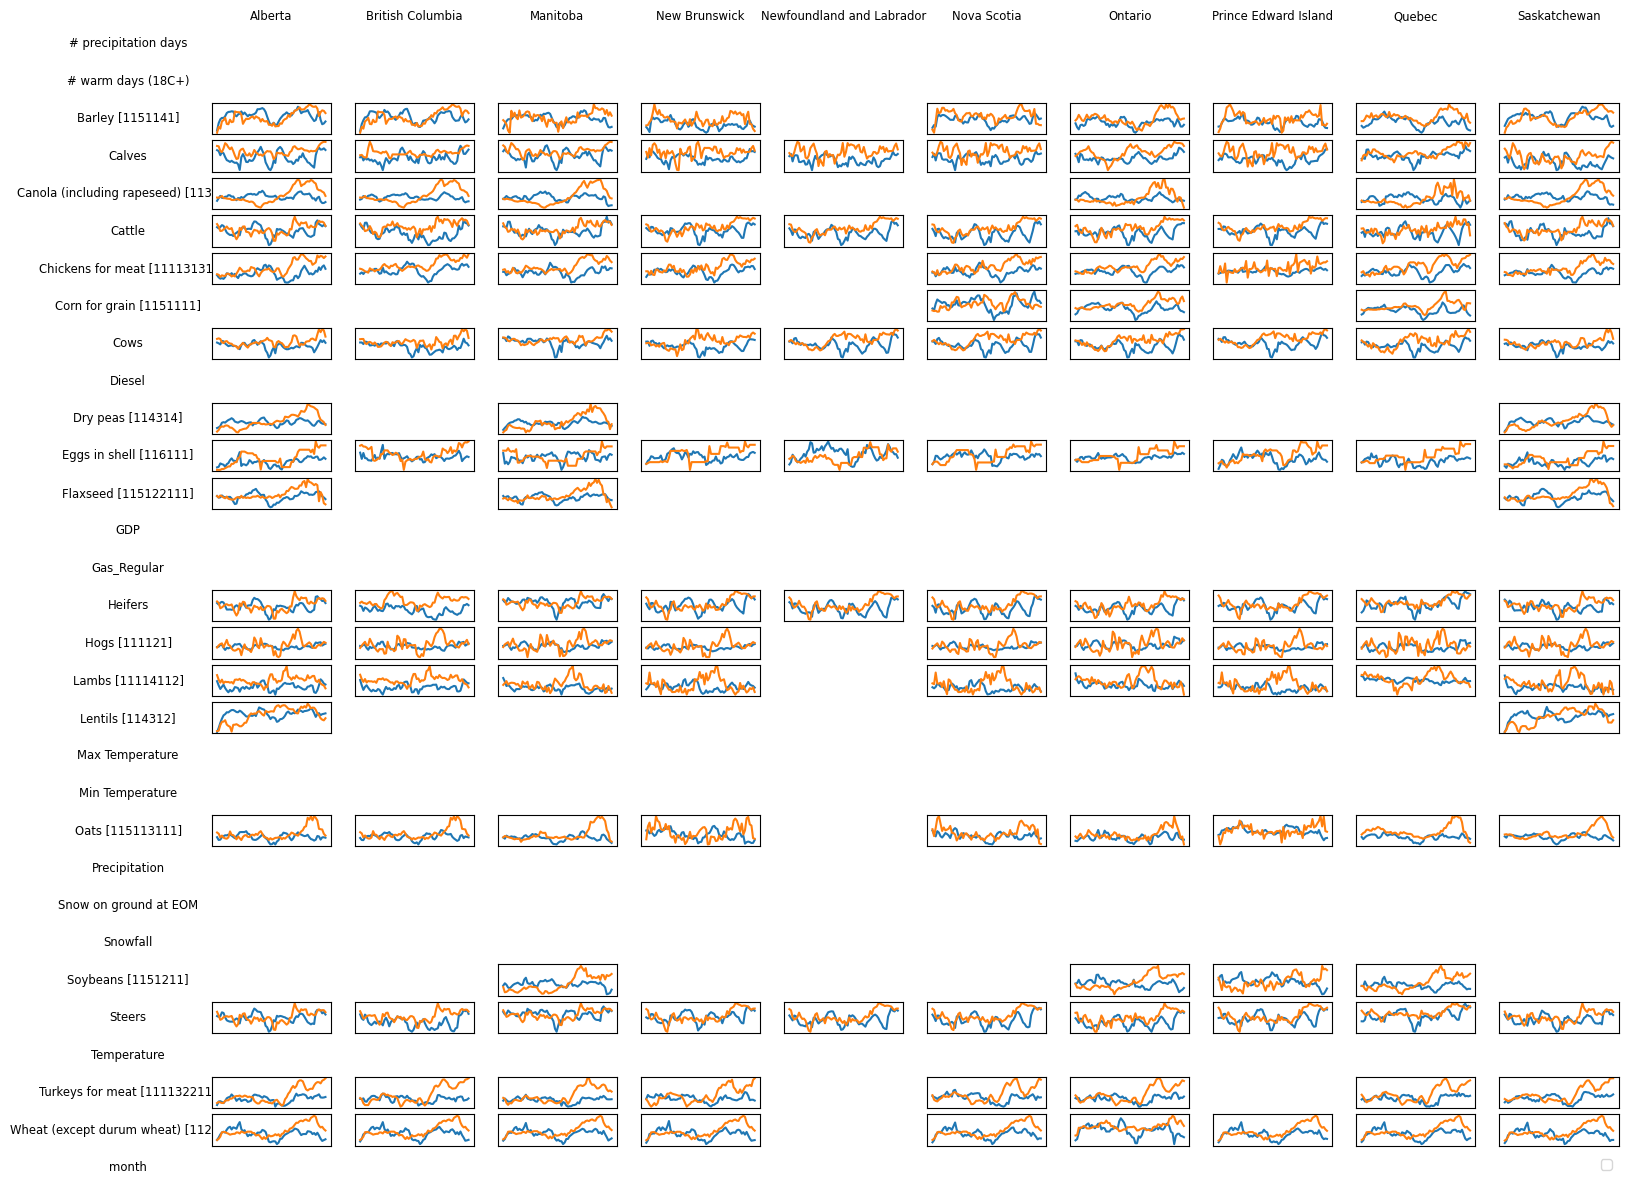

In [ ]:

predictions = model(X_test).detach().numpy()
y_test_scaled = y_test #[1:, :] - y_test[:-1, :]

products = np.unique( [c[1] for c in df.columns] )
provinces = np.unique( [c[0] for c in df.columns] )

fig, axes = plt.subplots(nrows=31, ncols=11, figsize=(20, 15))

for i in range(31):
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])

    for j in range(0, 11):
        axes[i, j].axis('off')

for i in range(predictions.shape[1]):
    r = np.where(products == df.columns[i][1])[0][0]
    c = np.where(provinces == df.columns[i][0])[0][0] + 1

    axes[r, c].axis('on')
    axes[r, c].cla()

    axes[r, c].plot(predictions[:, i], label='Predicted Temperature')
    axes[r, c].plot(y_test_scaled[:, i], label='Actual Temperature')

    # Optional: Remove the x and y ticks for clarity
    axes[r, c].set_xticks([])
    axes[r, c].set_yticks([])

for j, col in enumerate(provinces):
    axes[0, j+1].set_title(col, size = 'small')

for ax, row in zip(axes[:,0], products):   
    ax.text(0.5, 0.5, row, ha='center', va='center', rotation=0, size='small')
    ax.axis('off')  # Turn off the axis for the label cells

#plt.tight_layout()
plt.legend()
plt.show()